In [1]:
import numpy as np
import pandas as pd
from utils import physics
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

filename = "LLNL_160809_freq.csv"
df = pd.read_csv("data/"+filename, header = None)
df.columns = ["Frequency (in THz)", "Wavelength (in nm)", "Intensity", "Phase (rad)", "Phase (cutted) (rad)"] 
frequency = df.loc[:, "Frequency (in THz)"].values * 10**12 # THz to Hz
field = np.sqrt(df.loc[:, "Intensity"].values)
central_carrier = 2294295618320813.0

num_points = int(1e3)
start_freq, end_freq = 351, 379

field_interpolator = interp1d(frequency, field)
frequency_spaced = np.linspace(start = start_freq, stop = end_freq, num = num_points, endpoint = True) * 10**12
field_spaced = field_interpolator(frequency_spaced)

frequency = frequency_spaced; field = field_spaced

ps = physics.PulseEmitter(frequency = frequency, field = field)

theorical_phase = physics.theorical_phase(frequency, central_carrier)
control_params = physics.phase_expansions(frequency, theorical_phase)
pulse = ps.temporal_profile(control_params)
timescale = ps.time_scale()

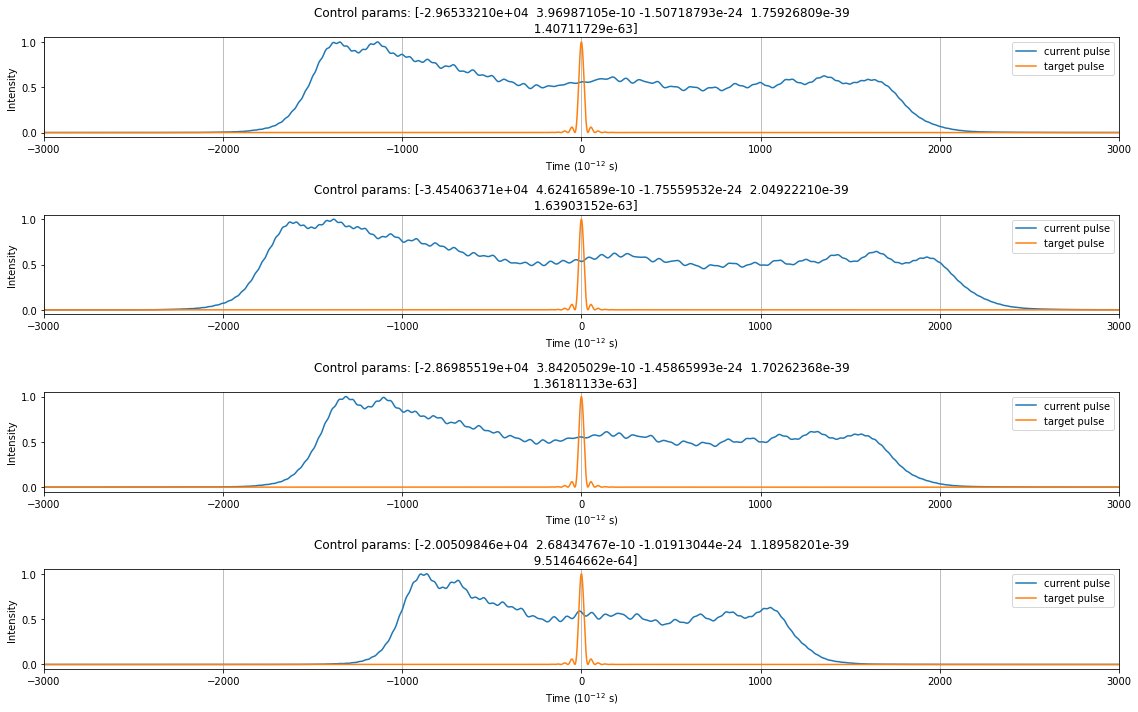

In [2]:
nrows = 4
fig, ax = plt.subplots(figsize = (16,10), nrows = nrows)

for i in range(nrows): 
    current = ax[i]
    modified_control_params = control_params + 5*np.random.random(size=1) * control_params
    modified_pulse = ps.temporal_profile(modified_control_params)
    current.set_title("Control params: " + str(modified_control_params)); current.set_xlabel(r"Time ($10^{-12}$ s)"); current.set_ylabel("Intensity")
    current.plot(timescale, modified_pulse, label = "current pulse")
    
    target_pulse = ps.temporal_profile(np.zeros_like(modified_control_params))
    current.plot(timescale, target_pulse, label = "target pulse")
    current.set_xlim(left = -3000, right = +3000)
    current.legend()
    current.grid(axis = "x")
fig.tight_layout()
plt.show()

ps_equation = physics.PulseEmitter(frequency, field, useEquation=True, central_carrier = central_carrier)

In [6]:
from bayes_opt import BayesianOptimization as BO

GDD_low, GDD_high = 20, 40
TOD_low, TOD_high = 10, 100
FOD_low, FOD_high = 10, 100

pbounds = {
    "GDD": (GDD_low, GDD_high), 
    "TOD": (TOD_low, TOD_high), 
    "FOD": (FOD_low, FOD_high)
}

objective_function = lambda GDD, TOD, FOD: -1 * physics.mse(ps_equation.temporal_profile(control_params = np.array([GDD, TOD, FOD])), target_pulse)

optimizer = BO(
    f=objective_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=7,
)

optimizer.maximize(
    init_points=100,
    n_iter=250,
)

|   iter    |  target   |    FOD    |    GDD    |    TOD    |
-------------------------------------------------------------
|  1        | -0.01649  |  16.87    |  35.6     |  49.46    |
|  2        | -0.02421  |  75.11    |  39.56    |  58.46    |
|  3        | -0.005999 |  55.1     |  21.44    |  34.16    |
|  4        | -0.007242 |  54.99    |  33.58    |  82.34    |
|  5        | -0.006621 |  44.28    |  21.32    |  35.93    |
|  6        | -0.000312 |  91.86    |  24.27    |  50.69    |
|  7        | -0.005038 |  93.81    |  20.5     |  64.05    |
|  8        | -0.000535 |  95.51    |  24.61    |  59.36    |
|  9        | -0.002771 |  91.82    |  22.66    |  57.11    |
|  10       | -0.01142  |  77.54    |  33.38    |  52.1     |
|  11       | -0.00595  |  28.44    |  29.82    |  43.51    |
|  12       | -0.001096 |  52.97    |  27.32    |  85.41    |
|  13       | -0.000387 |  79.18    |  26.28    |  61.54    |
|  14       | -0.005221 |  34.84    |  29.06    |  41.77    |
|  15   

|  101      | -0.007166 |  62.34    |  20.0     |  58.9     |
|  102      | -0.007762 |  30.62    |  20.0     |  56.58    |
|  103      | -0.005996 |  68.53    |  20.0     |  15.09    |
|  104      | -0.003007 |  100.0    |  20.0     |  100.0    |
|  105      | -0.006506 |  34.04    |  34.35    |  100.0    |
|  106      | -0.003425 |  11.75    |  20.03    |  93.66    |
|  107      | -0.00431  |  77.26    |  20.0     |  80.97    |
|  108      | -0.01069  |  10.0     |  20.0     |  45.93    |
|  109      | -0.003979 |  98.83    |  20.01    |  84.25    |
|  110      | -0.007465 |  86.98    |  20.1     |  25.51    |
|  111      | -0.003094 |  26.5     |  20.0     |  100.0    |
|  112      | -0.004814 |  46.99    |  20.17    |  73.31    |
|  113      | -0.008429 |  27.27    |  34.65    |  84.53    |
|  114      | -0.004393 |  10.0     |  20.0     |  81.24    |
|  115      | -0.005088 |  99.34    |  20.55    |  15.5     |
|  116      | -0.003384 |  100.0    |  28.96    |  68.19    |
|  117  

|  182      | -0.001045 |  67.43    |  25.37    |  82.57    |
|  183      | -0.000324 |  51.95    |  25.8     |  57.38    |
|  184      | -0.000663 |  11.68    |  26.97    |  81.28    |
|  185      | -0.001285 |  81.51    |  25.55    |  100.0    |
|  186      | -0.000684 |  57.7     |  26.28    |  99.51    |
|  187      | -0.00291  |  54.96    |  22.79    |  49.98    |
|  188      | -0.002896 |  87.07    |  20.52    |  91.45    |
|  189      | -0.000432 |  22.35    |  26.23    |  57.42    |
|  190      | -0.000392 |  99.57    |  23.89    |  62.48    |
|  191      | -0.000426 |  10.0     |  27.05    |  93.13    |
|  192      | -0.000390 |  29.78    |  26.37    |  64.84    |
|  193      | -0.001485 |  70.05    |  24.92    |  96.68    |
|  194      | -0.000295 |  36.66    |  26.0     |  69.21    |
|  195      | -0.001217 |  79.69    |  25.02    |  86.75    |
|  196      | -0.000685 |  28.01    |  25.93    |  87.25    |
|  197      | -0.001462 |  95.46    |  25.32    |  100.0    |
|  198  

|  263      | -0.001256 |  52.23    |  23.97    |  25.09    |
|  264      | -0.000303 |  77.01    |  26.22    |  79.68    |
|  265      | -0.00323  |  49.44    |  20.07    |  94.92    |
|  266      | -0.003    |  22.43    |  26.82    |  33.5     |
|  267      | -0.000559 |  18.06    |  24.12    |  42.62    |
|  268      | -2.745e-0 |  27.36    |  24.83    |  28.16    |
|  269      | -0.000929 |  77.98    |  25.14    |  73.59    |
|  270      | -2.791e-0 |  33.88    |  24.89    |  29.38    |
|  271      | -0.001141 |  90.52    |  25.6     |  95.0     |
|  272      | -0.001033 |  74.04    |  25.5     |  85.35    |
|  273      | -0.000215 |  64.05    |  25.08    |  14.4     |
|  274      | -0.005465 |  18.78    |  20.0     |  10.0     |
|  275      | -0.000377 |  58.7     |  26.13    |  81.4     |
|  276      | -0.000468 |  100.0    |  25.97    |  81.03    |
|  277      | -0.000477 |  98.65    |  26.93    |  87.37    |
|  278      | -0.003154 |  60.71    |  22.31    |  15.54    |
|  279  

|  344      | -0.003238 |  40.92    |  27.12    |  17.88    |
|  345      | -0.000146 |  34.67    |  24.64    |  15.61    |
|  346      | -0.000135 |  47.93    |  24.71    |  16.64    |
|  347      | -0.002963 |  45.68    |  26.69    |  33.59    |
|  348      | -0.000331 |  54.2     |  25.11    |  10.0     |
|  349      | -0.000380 |  36.52    |  25.56    |  58.19    |
|  350      | -0.000592 |  68.52    |  27.06    |  87.62    |


In [7]:
optimizer.max["params"]

{'FOD': 33.875512543717605,
 'GDD': 24.89171651233088,
 'TOD': 29.381360577408323}

(-400.0, 400.0)

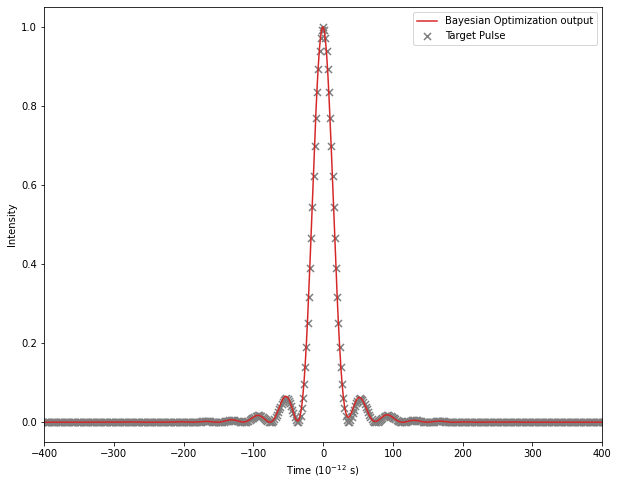

In [10]:
optimalGDD, optimalTOD, optimalFOD = optimizer.max["params"]["GDD"], optimizer.max["params"]["TOD"], optimizer.max["params"]["FOD"]
optimal_control = np.array([optimalGDD, optimalTOD, optimalFOD])

fig, ax = plt.subplots(figsize = (10,8))

ax.plot(timescale, ps_equation.temporal_profile(optimal_control), label = "Bayesian Optimization output", color = "tab:red")
ax.scatter(timescale, target_pulse, label = "Target Pulse", c = "tab:grey", marker = "x", s = 50)
ax.set_xlabel(r"Time ($10^{-12}$ s)"); ax.set_ylabel("Intensity")

ax.legend()
ax.set_xlim(left = -400, right = +400)